In [1]:
import os
import torch

save_dir = os.path.expanduser("~/YOLO_MODELS")
checkpoint_pth = save_dir + "/" + max([f for f in os.listdir(save_dir) if f.endswith(".pth")])

In [2]:
from models import YOLOv1
from data.VOC_Dataset import VOC_Dataset
from data import DATA_HOME

from ipdb import set_trace
from torch.utils.data import DataLoader
from numpy import array
from multiprocessing import cpu_count
import random 
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

random.seed(1)
torch.manual_seed(1)

In [3]:
import platform

_voc_root = f"{DATA_HOME}/VOCdevkit/VOC2007"
voc_ds = VOC_Dataset(_voc_root)
BS = 1

def collate_fn(data):
    # output: 7 * 7 * 30
    # S * S * ((x, y, w, h, confidence) * B=2 + C=20)
    # make img batch and label batch
    imgs, labels, classes = zip(*data)
    # inhomegenous shape label, since each image has different number of objects
    # label's dimension: (Batch size, # of objects in each image, 4 coords)
    return torch.tensor(array(imgs), dtype=torch.float), labels, classes
    
if platform.system() == "Windows":
    loader = DataLoader(voc_ds, batch_size=BS, pin_memory=True, shuffle=True, collate_fn=collate_fn)
else:
    loader = DataLoader(voc_ds, batch_size=BS, pin_memory=True, shuffle=True, num_workers=4, collate_fn=collate_fn)

class dict:  {'horse': 0, 'pottedplant': 1, 'aeroplane': 2, 'bird': 3, 'bottle': 4, 'tvmonitor': 5, 'boat': 6, 'sofa': 7, 'person': 8, 'diningtable': 9, 'dog': 10, 'bicycle': 11, 'sheep': 12, 'motorbike': 13, 'chair': 14, 'bus': 15, 'train': 16, 'car': 17, 'cow': 18, 'cat': 19}


In [4]:
yolo = YOLOv1().to(device=device)
yolo.load_state_dict(torch.load(checkpoint_pth)["model"])
# set_trace()
S = 7 # num of rows/cols
C = 20 # num of classes
B = 2 # num of bounding boxes

lamba_coord = 5
lamba_noobj = 0.5

In [5]:
from utils.display import display_image_bbox
from utils.metrics import xywh_2_xxyy
import numpy as np

with torch.no_grad():
    for _, (batch, labels, classes) in enumerate(loader):
        res = yolo(batch.to(device=device)).squeeze(0)
        # set_trace()
        boxes = []
        for i in range(res.shape[1]):
            for j in range(res.shape[2]):
                cell1 = res[:, i, j][:5]
                cell2 = res[:, i, j][5:10]
                boxes.append(cell1.detach().cpu().numpy())
                boxes.append(cell2.detach().cpu().numpy())
                

        boxes = list(map(xywh_2_xxyy, boxes))

        boxes = [np.maximum(.0, np.array(b)) for b in boxes]
        boxes = [(min(b[0], b[2]), min(b[1], b[3]), b[2], b[3]) for b in boxes]
        
        display_image_bbox(batch[0], boxes)
        # set_trace()

loss_df:             l1        l2        l3         l4         l5
0    1.897655  2.033219  0.243693  23.241043  24.970455
1    3.363088  2.825913  0.510017  22.727676  35.024807
2    3.053658  1.120423  0.318360  23.960028   9.997408
3    6.264967  2.338710  0.726130  23.195482  25.010735
4    4.675645  1.819422  0.689878  23.166563  25.025898
5    2.775415  1.077777  0.396902  23.630127  14.977925
6    1.455355  0.389552  0.228028  23.840933   9.995462
7    2.126151  0.891208  0.217360  23.801559   9.948074
8    6.147079  3.347744  1.115804  23.020008  24.985302
9    3.665082  1.727788  0.461007  23.468508  14.986922
10   4.352588  2.186596  0.532176  23.415220  14.993997
11   3.320683  1.447206  0.416747  23.355484  14.933432
12   7.447117  2.922480  1.010264  22.819010  24.885906
13   6.690135  4.723296  0.921834  22.269911  34.948257
14   3.528804  1.831406  0.311436  22.956467  19.951572
15   4.681461  1.724133  0.572109  23.122576  14.898476
16   4.137114  1.361261  0.538524  23.

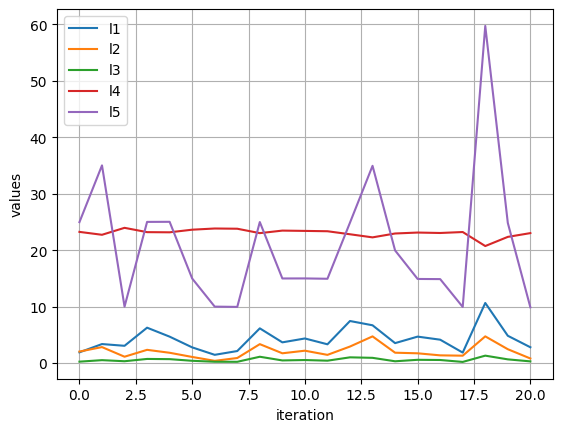

loss_df:             l1         l2        l3         l4          l5
0    6.457714   1.709566  0.662175  23.478474   20.010614
1    8.120255   3.952374  2.092281  22.455957   39.980442
2    3.462290   2.158022  0.377364  23.687597   15.002409
3    5.962920   2.293360  1.288113  23.160864   24.981167
4    5.309159   2.210654  0.627949  23.133694   24.976387
5    4.458586   2.785290  0.656827  22.847143   29.976498
6   10.493639   5.626980  1.991032  21.566521   54.923416
7    5.589000   1.741631  0.936888  22.276100   39.942810
8    3.842751   1.395934  0.615484  23.213602   20.021059
9    1.584006   0.421746  0.196696  23.659218    9.945667
10  32.147053  14.053105  5.444075  18.208834  119.860222
11  11.117146   5.394074  2.352685  20.362715   74.840393
12   2.924697   1.369610  0.279255  23.242159   14.968247
13   8.444302   3.074269  1.472002  22.199402   34.901932
14   0.851624   1.026300  0.077807  23.125175   14.969666
15   6.105246   4.038775  0.619125  22.576048   24.878252
16  

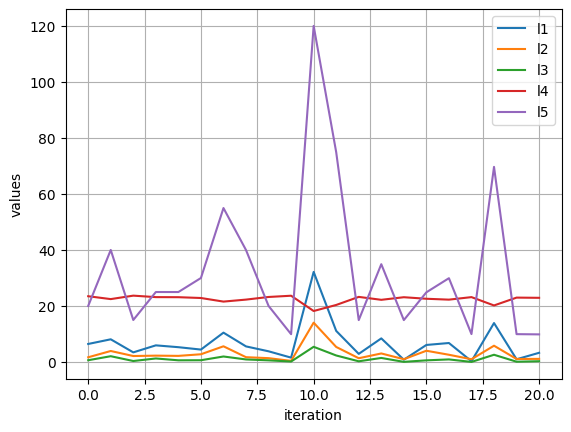

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
loss_dir = os.path.expanduser("~/YOLO_MODELS")
for fname in ["/train_loss_latest.csv", "/val_loss_latest.csv"]:
    loss_df = pd.read_csv(loss_dir + fname, index_col=0)
    print("loss_df: ", loss_df)
    for col in loss_df.columns:
        # if col == "l1" or col == "l2": #or col == "l5":
        plt.plot(loss_df[col], label=col)
    plt.xlabel("iteration")
    plt.ylabel("values")
    plt.legend()
    plt.grid(True)
    plt.show()